<a href="https://colab.research.google.com/github/ValenDiazzz/MachineLearning/blob/main/LoanDefaultPrediction_FullProyect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Loan Default Prediction Based on Debt Habits

Predicting individuals who may default on loans is highly beneficial for both the debtors and the creditors. Being aware of the potential consequences of their current debt habits allows the debtors to mitigate possible negative impacts on their personal lives. For the creditors, identifying individuals prone to defaulting on payments enables them to take risk mitigation measures, such as limiting credit or setting higher interest rates.

However, it is not only crucial to accurately predict those who will default, but also those who will not. This way, creditors can avoid missing opportunities to grant credit to creditworthy customers, potentially increasing their profitability.

## Summary

* The raw database was transformed into a table format.
* From this data, features were constructed to create a dataset.
* The goal was to predict whether a person would default in the next two months based on their debt habits over the past 12 months, using various classification algorithms.

## Models
For the classification task we have used the following classification algorithms:

1. Naive-Bayes
2. KNN
3. Logistic Regression
4. Decision Tree
5. Random Forest
6. Gradient Boosting



## About the Dataset
The original dataset used was from CENDEU of the BCRA. It contains debt information for the last 2 years, up until March 2023, recorded by the Central Bank of the Argentine Republic for various financial entities. The dataset was obtained from the following repository:
https://github.com/Giuppone/Diplodatos2023

The dataset was originally in a .txt file where the fields were separated by their lengths. Within this file, we had the following information:
1. **Financial Entity:**

  Id of the reporting entity.

2. **Debtor Identification Type.**

3. **Debtor Identification:**

  CUIT or CUIL, which are randomized to preserve the anonymity of the debtors.
4. **Situation:**

  1. Normal | Delay in payment of up to 31 days.

  2. Low Risk | Delay in payment of more than 31 up to 90 days past due.

  3. Medium Risk | Delay in payment of more than 90 up to 180 days.

  4. High Risk | Delay in payment of more than 180 days up to one year.

  5. Irrecoverable | Delays exceeding one year.


5. **Debt Amount:**
  Information in thousands of Argentine peso.

## What is considered as Default?

The following Default definition will be used:

***An individual will be considered in default if the amount of debt overdue for more than 90 days reaches at least 10% of the total debt held with all financial entities.***

## Data Processing
In order to work with the data it was needed to parse the .txt and generate a dataframe. Additionally, the following considerations were taken into account for the analysis:

1. It were excluded records of non-physical persons.

2. The time window for analyzing debt habits was narrowed down.

3. Records of individuals who did not have any debt during the analysis time frame were excluded.

4. Due to Argentina's high inflation rates, the debt amounts were updated with respect to the variation in the Consumer Price Index (CPI).

Based on these considerations, 565,889 rows and 30 columns were obtained.

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
path= './24DSF.txt'

In [ ]:
#Parser
def getData(file_path):
    with open(file_path, 'r') as file:
        result = []
        for line in file:
            if line[5:7] == "11":
                entry = [line[0:5],line[5:7], line[7:18]]
                l = len(line[18:len(line)-1])
                for i in range(24):
                    sit = line[18+ i*15: 20+ i*15]
                    amo = line[20+ i*15: 32+ i*15]
                    entry.append(sit)
                    entry.append(amo)
                result.append(entry)

    for i, e in enumerate(result):
        for j, s in enumerate(e):
            result[i][j] = s.strip()
            if "," in s:
                result[i][j] = float(s.replace(",","."))
            else:
                result[i][j] = int(result[i][j])
    return result

In [ ]:
parsed_data= getData(path)
columns= ['Entities', 'Id_Type', 'Id', 'sit01', 'am01',
          'sit02', 'am02', 'sit03', 'am03', 'sit04',
          'am04','sit05','am05','sit06','am06','sit07','am07',
          'sit08','am08','sit09','am09','sit10','am10','sit11',
          'am11','sit12','am12','sit13','am13','sit14','am14',
          'sit15','am15','sit16','am16','sit17','am17','sit18',
          'am18','sit19','am19','sit20','am20','sit21','am21',
          'sit22','am22','sit23','am23','sit24','am24']
df= pd.DataFrame(parsed_data, columns=columns)

In [ ]:
#Borramos filas que no presentan deudas en el ultimo año (mes 11 hasta 22)
sit_sum= df.iloc[:, 23:-4].iloc[:,::2].sum(axis=1)
del_idx= sit_sum[sit_sum == 0].index
df= df.drop(del_idx)
df.index= list(range(df.shape[0]))

#Nos quedamos con los ultimos 14 meses. 12 de prediccion y 2 para target
df= df.iloc[:,[0,1,2] + list(range(23,51))]

#Borramos columna Id_Type
df= df.drop('Id_Type', axis=1)

In [ ]:
#Actualizamos los montos de deuda con respecto a la variación del IPC
file_ipc = './EvolIPC.txt'

#Cargamos el IPC por mes.
ipc_values = []
with open(file_ipc, "r") as ipc_txt:
    for line in ipc_txt:
        ipc_values.append(float(line))

#Calculamos su variación
ipc_percentages = [(ipc_values[0]/x - 1) * 100 for x in ipc_values]

#Actualizamos Valores
am_cols = ["am24", "am23", "am22", "am21", "am20", "am19", "am18", "am17", "am16", "am15", "am14", "am13", "am12", "am11"]
for i, am_col in enumerate(am_cols):
    df[am_col] = df[am_col] * (1 + ipc_percentages[i] / 100)

In [ ]:
print(df.shape)

(565889, 30)


In [ ]:
df.head()

,Entities,Id,sit11,am11,sit12,am12,sit13,am13,sit14,am14,...,sit20,am20,sit21,am21,sit22,am22,sit23,am23,sit24,am24
0,34,20117694323,1,281.275732,1,267.628420,1,96.323276,1,122.868072,...,1,93.418637,1,101.037893,1,91.849317,1,53.837620,1,82.0
1,55311,24259829375,1,28.345616,0,0.000000,0,0.000000,1,1.833852,...,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.0
2,259,20346215355,0,0.000000,0,0.000000,0,0.000000,0,0.000000,...,0,0.000000,0,0.000000,1,1.148116,1,5.383762,1,4.0
3,55107,20309956294,5,10.902160,5,10.214825,5,9.632328,5,9.169259,...,5,6.398537,5,6.086620,5,5.740582,5,5.383762,5,5.0
4,55002,20231787127,1,235.486659,1,257.413595,1,275.484570,1,273.243922,...,1,142.047517,2,154.600150,1,153.847607,1,110.905498,1,104.0


## Feature Creation
From the dataset acquired previously, we will generate various features that will help us predict if a debtor will default in the next 2 months. Instead of using the full 24 months of data, we will use data from months 11 to 22 to create the features for individuals who are not in default. We will use the data from months 23 and 24 to identify which of these individuals are now in default. The features created are as follows:

1. ***Total_Debt*** : Total debt amount.

2. ***Amount_of_Entities*** : Number of financial entities in which the person took out debt.

3. ***Min_Debt*** : Lower amount of debt of the person.

4. ***Max_Debt*** : Greater amount of debt of the person.

5. ***Best_Sit_C1*** : Best situation of the person during the first four-month period.

6. ***Best_Sit_C2*** : Best situation of the person during the second four-month period.

7. ***Best_Sit_C3*** : Best situation of the person during the third four-month period.

8. ***Worst_Sit_C1*** : Worst situation of the person during the first four-month period.

9. ***Worst_Sit_C2*** : Worst situation of the person during the second four-month period.

10. ***Worst_Sit_C3*** : Worst situation of the person during the third four-month period.

11. ***Sit1_Pct*** : Proportion of debt of the person who is in situation 1.

12. ***Sit2_Pct*** : Proportion of debt of the person who is in situation 2.

13. ***Sit3_Pct*** : Proportion of debt of the person who is in situation 3.

14. ***Sit4_Pct*** : Proportion of debt of the person who is in situation 4.

15. ***Sit5_Pct*** : Proportion of debt of the person who is in situation 5.

We will use the SQL to facilitate the creation of features.

In [ ]:
!pip install pandas-gbq google-auth

In [ ]:
import sqlite3
conn= sqlite3.connect(':memory:')
df.to_sql('df', conn, index=False, if_exists='replace')

565889

In [ ]:
query= 'SELECT Id, SUM(am11 + am12 + am13 + am14 + am15 + am16 + am17 + am18 + am19 + am20 + am21 + am22) AS Total_Deuda FROM df GROUP BY Id;'
monto_deuda_total= pd.read_sql_query(query, conn)
monto_deuda_total.to_sql('monto_deuda_total', conn, index=False, if_exists='replace')

query= 'SELECT Id, COUNT(DISTINCT Entities) AS Total_Entities FROM df GROUP BY Id ;'
Total_Entities= pd.read_sql_query(query, conn)
Total_Entities.to_sql('Total_Entities', conn, index=False, if_exists='replace')

query= 'SELECT Id, MIN(am11, am12, am13, am14, am15, am16, am17, am18, am19, am20, am21, am22) AS Minimo_Monto_Deuda FROM df GROUP BY Id;'
Min_Monto= pd.read_sql_query(query, conn)
Min_Monto.to_sql('Min_Monto', conn, index=False, if_exists='replace')

query= 'SELECT Id, MAX(am11, am12, am13, am14, am15, am16, am17, am18, am19, am20, am21, am22) AS Max_Monto_Deuda FROM df GROUP BY Id;'
Max_Monto= pd.read_sql_query(query, conn)
Max_Monto.to_sql('Max_Monto', conn, index=False, if_exists='replace')

query= 'SELECT Id, MIN(sit11, sit12, sit13, sit14) AS Mejor_Sit_C1, MIN(sit15, sit16, sit17, sit18) AS Mejor_Sit_C2, MIN(sit19, sit20, sit21, sit21) AS Mejor_Sit_C3 FROM df GROUP BY Id;'
Mejor_Sit= pd.read_sql_query(query, conn)
Mejor_Sit.to_sql('Mejor_Sit', conn, index=False, if_exists='replace')

query= 'SELECT Id, MAX(sit11, sit12, sit13, sit14) AS Peor_Sit_C1, MAX(sit15, sit16, sit17, sit18) AS Peor_Sit_C2, MAX(sit19, sit20, sit21, sit21) AS Peor_Sit_C3 FROM df GROUP BY Id;'
Peor_Sit= pd.read_sql_query(query, conn)
Peor_Sit.to_sql('Peor_Sit', conn, index=False, if_exists='replace')

query= 'SELECT Id, SUM(CASE WHEN sit11 = 1 THEN am11 ELSE 0 END + CASE WHEN sit12 = 1 THEN am12 ELSE 0 END + CASE WHEN sit13 = 1 THEN am13 ELSE 0 END + CASE WHEN sit14 = 1 THEN am14 ELSE 0 END + CASE WHEN sit15 = 1 THEN am15 ELSE 0 END + CASE WHEN sit16 = 1 THEN am16 ELSE 0 END + CASE WHEN sit17 = 1 THEN am17 ELSE 0 END + CASE WHEN sit18 = 1 THEN am18 ELSE 0 END + CASE WHEN sit19 = 1 THEN am19 ELSE 0 END + CASE WHEN sit20 = 1 THEN am20 ELSE 0 END + CASE WHEN sit21 = 1 THEN am21 ELSE 0 END + CASE WHEN sit22 = 1 THEN am22 ELSE 0 END) AS Monto_Total_Deuda_Situacion_1 FROM df GROUP BY Id;'
Total_Deuda_Sit1= pd.read_sql_query(query, conn)
Total_Deuda_Sit1.to_sql('Total_Deuda_Sit1', conn, index=False, if_exists='replace')

query= 'SELECT Id, SUM(CASE WHEN sit11 = 2 THEN am11 ELSE 0 END + CASE WHEN sit12 = 2 THEN am12 ELSE 0 END + CASE WHEN sit13 = 2 THEN am13 ELSE 0 END + CASE WHEN sit14 = 2 THEN am14 ELSE 0 END + CASE WHEN sit15 = 2 THEN am15 ELSE 0 END + CASE WHEN sit16 = 2 THEN am16 ELSE 0 END + CASE WHEN sit17 = 2 THEN am17 ELSE 0 END + CASE WHEN sit18 = 2 THEN am18 ELSE 0 END + CASE WHEN sit19 = 2 THEN am19 ELSE 0 END + CASE WHEN sit20 = 2 THEN am20 ELSE 0 END + CASE WHEN sit21 = 2 THEN am21 ELSE 0 END + CASE WHEN sit22 = 2 THEN am22 ELSE 0 END) AS Monto_Total_Deuda_Situacion_2 FROM df GROUP BY Id;'
Total_Deuda_Sit2= pd.read_sql_query(query, conn)
Total_Deuda_Sit2.to_sql('Total_Deuda_Sit2', conn, index=False, if_exists='replace')

query= 'SELECT Id, SUM(CASE WHEN sit11 = 3 THEN am11 ELSE 0 END + CASE WHEN sit12 = 3 THEN am12 ELSE 0 END + CASE WHEN sit13 = 3 THEN am13 ELSE 0 END + CASE WHEN sit14 = 3 THEN am14 ELSE 0 END + CASE WHEN sit15 = 3 THEN am15 ELSE 0 END + CASE WHEN sit16 = 3 THEN am16 ELSE 0 END + CASE WHEN sit17 = 3 THEN am17 ELSE 0 END + CASE WHEN sit18 = 3 THEN am18 ELSE 0 END + CASE WHEN sit19 = 3 THEN am19 ELSE 0 END + CASE WHEN sit20 = 3 THEN am20 ELSE 0 END + CASE WHEN sit21 = 3 THEN am21 ELSE 0 END + CASE WHEN sit22 = 3 THEN am22 ELSE 0 END) AS Monto_Total_Deuda_Situacion_3 FROM df GROUP BY Id;'
Total_Deuda_Sit3= pd.read_sql_query(query, conn)
Total_Deuda_Sit3.to_sql('Total_Deuda_Sit3', conn, index=False, if_exists='replace')

query= 'SELECT Id, SUM(CASE WHEN sit11 = 4 THEN am11 ELSE 0 END + CASE WHEN sit12 = 4 THEN am12 ELSE 0 END + CASE WHEN sit13 = 4 THEN am13 ELSE 0 END + CASE WHEN sit14 = 4 THEN am14 ELSE 0 END + CASE WHEN sit15 = 4 THEN am15 ELSE 0 END + CASE WHEN sit16 = 4 THEN am16 ELSE 0 END + CASE WHEN sit17 = 4 THEN am17 ELSE 0 END + CASE WHEN sit18 = 4 THEN am18 ELSE 0 END + CASE WHEN sit19 = 4 THEN am19 ELSE 0 END + CASE WHEN sit20 = 4 THEN am20 ELSE 0 END + CASE WHEN sit21 = 4 THEN am21 ELSE 0 END + CASE WHEN sit22 = 4 THEN am22 ELSE 0 END) AS Monto_Total_Deuda_Situacion_4 FROM df GROUP BY Id;'
Total_Deuda_Sit4= pd.read_sql_query(query, conn)
Total_Deuda_Sit4.to_sql('Total_Deuda_Sit4', conn, index=False, if_exists='replace')

query= 'SELECT Id, SUM(CASE WHEN sit11 = 5 THEN am11 ELSE 0 END + CASE WHEN sit12 = 5 THEN am12 ELSE 0 END + CASE WHEN sit13 = 5 THEN am13 ELSE 0 END + CASE WHEN sit14 = 5 THEN am14 ELSE 0 END + CASE WHEN sit15 = 5 THEN am15 ELSE 0 END + CASE WHEN sit16 = 5 THEN am16 ELSE 0 END + CASE WHEN sit17 = 5 THEN am17 ELSE 0 END + CASE WHEN sit18 = 5 THEN am18 ELSE 0 END + CASE WHEN sit19 = 5 THEN am19 ELSE 0 END + CASE WHEN sit20 = 5 THEN am20 ELSE 0 END + CASE WHEN sit21 = 5 THEN am21 ELSE 0 END + CASE WHEN sit22 = 5 THEN am22 ELSE 0 END) AS Monto_Total_Deuda_Situacion_5 FROM df GROUP BY Id;'
Total_Deuda_Sit5= pd.read_sql_query(query, conn)
Total_Deuda_Sit5.to_sql('Total_Deuda_Sit5', conn, index=False, if_exists='replace')

query= 'SELECT monto_deuda_total.Id AS Id, Total_Deuda_Sit1.Monto_Total_Deuda_Situacion_1 / monto_deuda_total.Total_Deuda AS Proporcion_Sit1, Total_Deuda_Sit2.Monto_Total_Deuda_Situacion_2 / monto_deuda_total.Total_Deuda AS Proporcion_Sit2, Total_Deuda_Sit3.Monto_Total_Deuda_Situacion_3 / monto_deuda_total.Total_Deuda AS Proporcion_Sit3, Total_Deuda_Sit4.Monto_Total_Deuda_Situacion_4 / monto_deuda_total.Total_Deuda AS Proporcion_Sit4, Total_Deuda_Sit5.Monto_Total_Deuda_Situacion_5 / monto_deuda_total.Total_Deuda AS Proporcion_Sit5 FROM monto_deuda_total JOIN Total_Deuda_Sit1 ON monto_deuda_total.Id = Total_Deuda_Sit1.Id JOIN Total_Deuda_Sit2 ON monto_deuda_total.Id = Total_Deuda_Sit2.Id JOIN Total_Deuda_Sit3 ON monto_deuda_total.Id = Total_Deuda_Sit3.Id JOIN Total_Deuda_Sit4 ON monto_deuda_total.Id = Total_Deuda_Sit4.Id JOIN Total_Deuda_Sit5 ON monto_deuda_total.Id = Total_Deuda_Sit5.Id;'
Pct_Deuda_Sit= pd.read_sql_query(query, conn)
Pct_Deuda_Sit.to_sql('Pct_Deuda_Sit', conn, index=False, if_exists='replace')

query= 'SELECT monto_deuda_total.Id AS Id, monto_deuda_total.Total_Deuda AS Total_Debt, Total_Entities.Total_Entities AS Amount_of_Entities, Min_Monto.Minimo_Monto_Deuda AS Min_Debt, Max_Monto.Max_Monto_Deuda AS Max_Debt, Mejor_Sit.Mejor_Sit_C1 AS Best_Sit_C1, Mejor_Sit.Mejor_Sit_C2 AS Best_Sit_C2, Mejor_Sit.Mejor_Sit_C3 AS Best_Sit_C3, Peor_Sit.Peor_Sit_C1 AS Worst_Sit_C1,			 Peor_Sit.Peor_Sit_C2 AS Worst_Sit_C2, Peor_Sit.Peor_Sit_C3 AS Worst_Sit_C3, Pct_Deuda_Sit.Proporcion_Sit1 AS Sit1_Pct, Pct_Deuda_Sit.Proporcion_Sit2 AS Sit2_Pct, Pct_Deuda_Sit.Proporcion_Sit3 AS Sit3_Pct, Pct_Deuda_Sit.Proporcion_Sit4 AS Sit4_Pct, Pct_Deuda_Sit.Proporcion_Sit5 AS Sit5_Pct FROM monto_deuda_total JOIN Total_Entities ON monto_deuda_total.Id = Total_Entities.Id JOIN Min_Monto ON monto_deuda_total.Id = Min_Monto.Id JOIN Max_Monto ON monto_deuda_total.Id = Max_Monto.Id JOIN Mejor_Sit ON monto_deuda_total.Id = Mejor_Sit.Id JOIN Peor_Sit ON monto_deuda_total.Id = Peor_Sit.Id JOIN Pct_Deuda_Sit ON monto_deuda_total.Id = Pct_Deuda_Sit.Id;'
data= pd.read_sql_query(query, conn)
data.to_sql('data', conn, index=False, if_exists='replace')

301471

In [ ]:
print(data.shape[0])

301471


In [ ]:
#Getting rid of records with people on default.
data= data[ (data['Sit3_Pct'] + data['Sit4_Pct'] +data['Sit5_Pct'])<0.1]
data.to_sql('data', conn, index=False, if_exists='replace')

244117

In [ ]:
print(data.shape[0])

244117


There were a total of 301471 people in the dataset. Of these, 244,117 did not default from month 11 to 22.

With the following code, we will identify individuals who were in default from month 11 to month 24. Using this information, we will label the previous dataframe, enabling us to work on the prediction task.

In [ ]:
query= 'SELECT Id, SUM(am11 + am12 + am13 + am14 + am15 + am16 + am17 + am18 + am19 + am20 + am21 + am22 + am23 + am24) AS Total_Deuda FROM df GROUP BY Id;'
monto_deuda_total= pd.read_sql_query(query, conn)
monto_deuda_total.to_sql('monto_deuda_total', conn, index=False, if_exists='replace')

query= 'SELECT Id, SUM(CASE WHEN sit11 = 1 THEN am11 ELSE 0 END + CASE WHEN sit12 = 1 THEN am12 ELSE 0 END + CASE WHEN sit13 = 1 THEN am13 ELSE 0 END + CASE WHEN sit14 = 1 THEN am14 ELSE 0 END + CASE WHEN sit15 = 1 THEN am15 ELSE 0 END + CASE WHEN sit16 = 1 THEN am16 ELSE 0 END + CASE WHEN sit17 = 1 THEN am17 ELSE 0 END + CASE WHEN sit18 = 1 THEN am18 ELSE 0 END + CASE WHEN sit19 = 1 THEN am19 ELSE 0 END + CASE WHEN sit20 = 1 THEN am20 ELSE 0 END + CASE WHEN sit21 = 1 THEN am21 ELSE 0 END + CASE WHEN sit22 = 1 THEN am22 ELSE 0 END + CASE WHEN sit23 = 1 THEN am23 ELSE 0 END + CASE WHEN sit24 = 1 THEN am24 ELSE 0 END) AS Monto_Total_Deuda_Situacion_1 FROM df GROUP BY Id;'
Total_Deuda_Sit1= pd.read_sql_query(query, conn)
Total_Deuda_Sit1.to_sql('Total_Deuda_Sit1', conn, index=False, if_exists='replace')

query= 'SELECT Id, SUM(CASE WHEN sit11 = 2 THEN am11 ELSE 0 END + CASE WHEN sit12 = 2 THEN am12 ELSE 0 END + CASE WHEN sit13 = 2 THEN am13 ELSE 0 END + CASE WHEN sit14 = 2 THEN am14 ELSE 0 END + CASE WHEN sit15 = 2 THEN am15 ELSE 0 END + CASE WHEN sit16 = 2 THEN am16 ELSE 0 END + CASE WHEN sit17 = 2 THEN am17 ELSE 0 END + CASE WHEN sit18 = 2 THEN am18 ELSE 0 END + CASE WHEN sit19 = 2 THEN am19 ELSE 0 END + CASE WHEN sit20 = 2 THEN am20 ELSE 0 END + CASE WHEN sit21 = 2 THEN am21 ELSE 0 END + CASE WHEN sit22 = 2 THEN am22 ELSE 0 END + CASE WHEN sit23 = 1 THEN am23 ELSE 0 END + CASE WHEN sit24 = 1 THEN am24 ELSE 0 END) AS Monto_Total_Deuda_Situacion_2 FROM df GROUP BY Id;'
Total_Deuda_Sit2= pd.read_sql_query(query, conn)
Total_Deuda_Sit2.to_sql('Total_Deuda_Sit2', conn, index=False, if_exists='replace')

query= 'SELECT Id, SUM(CASE WHEN sit11 = 3 THEN am11 ELSE 0 END + CASE WHEN sit12 = 3 THEN am12 ELSE 0 END + CASE WHEN sit13 = 3 THEN am13 ELSE 0 END + CASE WHEN sit14 = 3 THEN am14 ELSE 0 END + CASE WHEN sit15 = 3 THEN am15 ELSE 0 END + CASE WHEN sit16 = 3 THEN am16 ELSE 0 END + CASE WHEN sit17 = 3 THEN am17 ELSE 0 END + CASE WHEN sit18 = 3 THEN am18 ELSE 0 END + CASE WHEN sit19 = 3 THEN am19 ELSE 0 END + CASE WHEN sit20 = 3 THEN am20 ELSE 0 END + CASE WHEN sit21 = 3 THEN am21 ELSE 0 END + CASE WHEN sit22 = 3 THEN am22 ELSE 0 END + CASE WHEN sit23 = 1 THEN am23 ELSE 0 END + CASE WHEN sit24 = 1 THEN am24 ELSE 0 END) AS Monto_Total_Deuda_Situacion_3 FROM df GROUP BY Id;'
Total_Deuda_Sit3= pd.read_sql_query(query, conn)
Total_Deuda_Sit3.to_sql('Total_Deuda_Sit3', conn, index=False, if_exists='replace')

query= 'SELECT Id, SUM(CASE WHEN sit11 = 4 THEN am11 ELSE 0 END + CASE WHEN sit12 = 4 THEN am12 ELSE 0 END + CASE WHEN sit13 = 4 THEN am13 ELSE 0 END + CASE WHEN sit14 = 4 THEN am14 ELSE 0 END + CASE WHEN sit15 = 4 THEN am15 ELSE 0 END + CASE WHEN sit16 = 4 THEN am16 ELSE 0 END + CASE WHEN sit17 = 4 THEN am17 ELSE 0 END + CASE WHEN sit18 = 4 THEN am18 ELSE 0 END + CASE WHEN sit19 = 4 THEN am19 ELSE 0 END + CASE WHEN sit20 = 4 THEN am20 ELSE 0 END + CASE WHEN sit21 = 4 THEN am21 ELSE 0 END + CASE WHEN sit22 = 4 THEN am22 ELSE 0 END + CASE WHEN sit23 = 1 THEN am23 ELSE 0 END + CASE WHEN sit24 = 1 THEN am24 ELSE 0 END) AS Monto_Total_Deuda_Situacion_4 FROM df GROUP BY Id;'
Total_Deuda_Sit4= pd.read_sql_query(query, conn)
Total_Deuda_Sit4.to_sql('Total_Deuda_Sit4', conn, index=False, if_exists='replace')

query= 'SELECT Id, SUM(CASE WHEN sit11 = 5 THEN am11 ELSE 0 END + CASE WHEN sit12 = 5 THEN am12 ELSE 0 END + CASE WHEN sit13 = 5 THEN am13 ELSE 0 END + CASE WHEN sit14 = 5 THEN am14 ELSE 0 END + CASE WHEN sit15 = 5 THEN am15 ELSE 0 END + CASE WHEN sit16 = 5 THEN am16 ELSE 0 END + CASE WHEN sit17 = 5 THEN am17 ELSE 0 END + CASE WHEN sit18 = 5 THEN am18 ELSE 0 END + CASE WHEN sit19 = 5 THEN am19 ELSE 0 END + CASE WHEN sit20 = 5 THEN am20 ELSE 0 END + CASE WHEN sit21 = 5 THEN am21 ELSE 0 END + CASE WHEN sit22 = 5 THEN am22 ELSE 0 END + CASE WHEN sit23 = 1 THEN am23 ELSE 0 END + CASE WHEN sit24 = 1 THEN am24 ELSE 0 END) AS Monto_Total_Deuda_Situacion_5 FROM df GROUP BY Id;'
Total_Deuda_Sit5= pd.read_sql_query(query, conn)
Total_Deuda_Sit5.to_sql('Total_Deuda_Sit5', conn, index=False, if_exists='replace')

query= 'SELECT monto_deuda_total.Id AS Id, Total_Deuda_Sit1.Monto_Total_Deuda_Situacion_1 / monto_deuda_total.Total_Deuda AS Proporcion_Sit1, Total_Deuda_Sit2.Monto_Total_Deuda_Situacion_2 / monto_deuda_total.Total_Deuda AS Proporcion_Sit2, Total_Deuda_Sit3.Monto_Total_Deuda_Situacion_3 / monto_deuda_total.Total_Deuda AS Proporcion_Sit3, Total_Deuda_Sit4.Monto_Total_Deuda_Situacion_4 / monto_deuda_total.Total_Deuda AS Proporcion_Sit4, Total_Deuda_Sit5.Monto_Total_Deuda_Situacion_5 / monto_deuda_total.Total_Deuda AS Proporcion_Sit5 FROM monto_deuda_total JOIN Total_Deuda_Sit1 ON monto_deuda_total.Id = Total_Deuda_Sit1.Id JOIN Total_Deuda_Sit2 ON monto_deuda_total.Id = Total_Deuda_Sit2.Id JOIN Total_Deuda_Sit3 ON monto_deuda_total.Id = Total_Deuda_Sit3.Id JOIN Total_Deuda_Sit4 ON monto_deuda_total.Id = Total_Deuda_Sit4.Id JOIN Total_Deuda_Sit5 ON monto_deuda_total.Id = Total_Deuda_Sit5.Id;'
Pct_Deuda_Sit= pd.read_sql_query(query, conn)
Pct_Deuda_Sit.to_sql('Pct_Deuda_Sit', conn, index=False, if_exists='replace')

301471

In [ ]:
default_after2= Pct_Deuda_Sit[(Pct_Deuda_Sit['Proporcion_Sit3'] + Pct_Deuda_Sit['Proporcion_Sit4'] + Pct_Deuda_Sit['Proporcion_Sit5'])>=0.1]
default_after2.to_sql('default_after2', conn, index=False, if_exists='replace')

221957

In [ ]:
#0 significa que la persona no entró en defualt en el mes 23 y 24, 1 significa que si entró en default.
query= 'SELECT t1.*, CASE WHEN t2.id IS NOT NULL THEN 1 ELSE 0 END AS Category FROM data t1 LEFT JOIN default_after2 t2 ON t1.id = t2.id;'
dataset= pd.read_sql_query(query, conn)
dataset.to_sql('dataset', conn, index=False, if_exists='replace')

244117

In [ ]:
dataset= dataset.drop(["Id"], axis=1)

In [ ]:
print(dataset.shape)
print(dataset[dataset['Category']==1].shape[0]/dataset.shape[0])
print(dataset[dataset['Category']==0].shape[0]/dataset.shape[0])

(244117, 16)
0.6744511852922984
0.32554881470770164


In [ ]:
dataset.to_csv("Cured_Dataset.csv")

**Finally our dataset has 244117 samples and 15 features. The proportion of data with Default category is 0.6744 and with No Default category is 0.3244.**

## Classifiers






In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
file_path= 'Cured_Dataset.csv'
dataset= pd.read_csv(file_path, index_col=0)

In [ ]:
dataset.shape

(244117, 16)

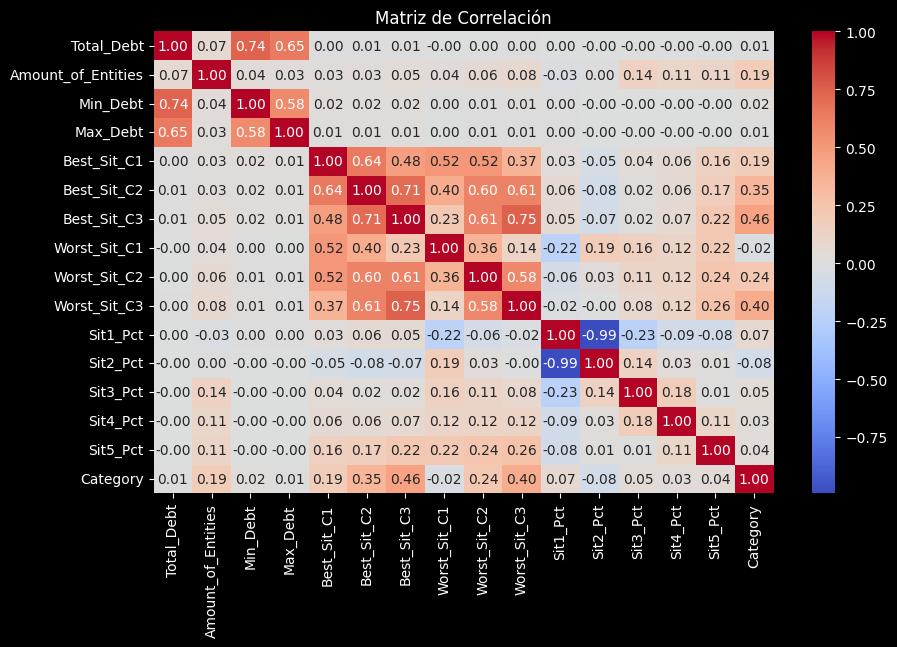

In [ ]:
plt.style.use("dark_background")
correlation_matrix = dataset.iloc[:,:].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

### Gaussian Naive Bayes


In [ ]:
data= dataset.drop(['Best_Sit_C1','Best_Sit_C2', 'Worst_Sit_C1', 'Worst_Sit_C2','Sit2_Pct' ,'Sit3_Pct'], axis=1)
#Eliminando data manteniendo la proporcion de las clases
np.random.seed(77)
data= data.groupby('Category').apply(lambda x: x.sample(frac=0.5)).reset_index(drop=True)

              precision    recall  f1-score   support

 Non-Default       0.67      0.70      0.68      7947
     Default       0.85      0.83      0.84     16465

    accuracy                           0.79     24412
   macro avg       0.76      0.76      0.76     24412
weighted avg       0.79      0.79      0.79     24412



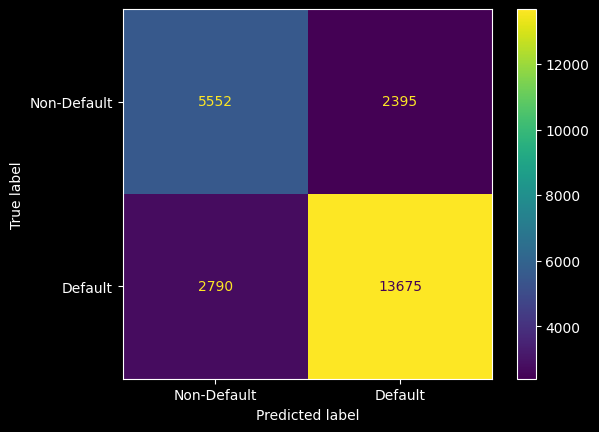

In [ ]:
X= data.iloc[:,:-1]
y= data.iloc[:,-1]

#Data splitting for training
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.20, stratify= y, random_state=77
)

#Estandarizamos los datos
scaler= StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

#dimension reduction first 10 components
pca= PCA(n_components=3)
X_train= pca.fit_transform(X_train)
X_test= pca.transform(X_test)

#Prediction
model= GaussianNB()
model.fit(X_train, y_train)
y_pred= model.predict(X_test)

#Results
print(classification_report(y_test, y_pred, target_names=['Non-Default','Default']))
cm= confusion_matrix(y_test, y_pred)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Default','Default'])
disp.plot()

### KNN

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
data= dataset.drop(['Best_Sit_C1','Best_Sit_C2', 'Worst_Sit_C1', 'Worst_Sit_C2','Sit2_Pct' ,'Sit3_Pct'], axis=1)
#Eliminando data manteniendo la proporcion de las clases
np.random.seed(77)
data = data.groupby('Category').apply(lambda x: x.sample(frac=0.5)).reset_index(drop=True)

In [ ]:
X= data.iloc[:,:-1]
y= data.iloc[:,-1]

#Data splitting for training
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.20, stratify= y, random_state=77
)

#Estandarizamos los datos
scaler= StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

#Prediction
parameters= {'n_neighbors': list(range(8,10)), 'weights':('uniform', 'distance')}
knn= KNeighborsClassifier()
clf= GridSearchCV(knn, parameters, cv=10)
clf.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [15, 16, 17, 18, 19],
                         'weights': ('uniform', 'distance')})

Best value for k: 9
Best weights: uniform
Mean test score: 0.8269155699705051


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.65      0.72      7947
           1       0.85      0.92      0.88     16465

    accuracy                           0.83     24412
   macro avg       0.82      0.78      0.80     24412
weighted avg       0.83      0.83      0.83     24412



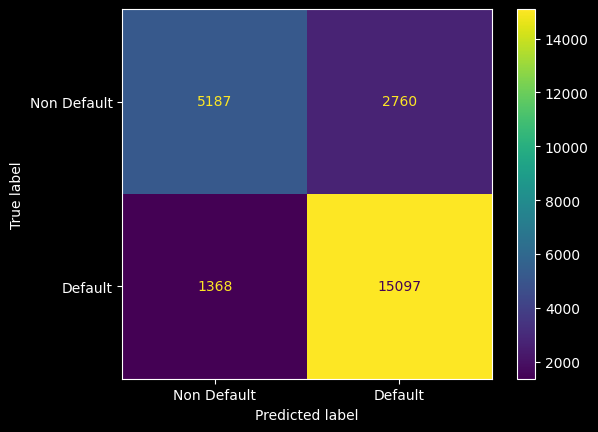

In [ ]:
#Best Parameters
best_k= clf.best_params_['n_neighbors']
best_weights= clf.best_params_['weights']
mean_test_score= clf.cv_results_['mean_test_score'][clf.best_index_]
print("Best value for k:", best_k)
print("Best weights:", best_weights)
print("Mean test score:", mean_test_score)

#Results
y_pred = clf.predict(X_test)
print("\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))
cm= confusion_matrix(y_test, y_pred)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non Default', 'Default'])
disp.plot()

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

In [ ]:
F=[
    ['Best_Sit_C1','Best_Sit_C2', 'Worst_Sit_C1', 'Worst_Sit_C2'],
    ['Best_Sit_C1','Worst_Sit_C1', 'Worst_Sit_C2'],
    ['Best_Sit_C1','Best_Sit_C2', 'Worst_Sit_C1', 'Worst_Sit_C2','Sit2_Pct'],
    ['Best_Sit_C1','Best_Sit_C2', 'Best_Sit_C3'],
    ['Best_Sit_C1','Best_Sit_C2', 'Min_Debt', 'Max_Debt','Sit2_Pct' ],
    ['Best_Sit_C1','Best_Sit_C2', 'Worst_Sit_C1', 'Worst_Sit_C2','Sit2_Pct' ,'Sit3_Pct'],
]

In [ ]:
for del_feature in F:

    data= dataset.drop(del_feature, axis=1)
    data = data.groupby('Category').apply(lambda x: x.sample(frac=0.5)).reset_index(drop=True)
    X= data.iloc[:,:-1]
    y= data.iloc[:,-1]

    X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, stratify=y, random_state=77)
    #Estandarizamos los datos
    scaler= StandardScaler()
    X_train= scaler.fit_transform(X_train)
    X_test= scaler.transform(X_test)

    logistic_cv= LogisticRegressionCV(cv=10, random_state=77, max_iter=5000)
    logistic_cv.fit(X_train, y_train)
    y_pred = logistic_cv.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

/var/folders/4g/w5x28zt906393qm46j_l8tzh0000gn/T/ipykernel_1906/1270890552.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('Category').apply(lambda x: x.sample(frac=0.5)).reset_index(drop=True)


Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.64      0.69      7947
           1       0.84      0.90      0.87     16465

    accuracy                           0.81     24412
   macro avg       0.79      0.77      0.78     24412
weighted avg       0.81      0.81      0.81     24412



/var/folders/4g/w5x28zt906393qm46j_l8tzh0000gn/T/ipykernel_1906/1270890552.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('Category').apply(lambda x: x.sample(frac=0.5)).reset_index(drop=True)


Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.64      0.69      7947
           1       0.84      0.89      0.87     16465

    accuracy                           0.81     24412
   macro avg       0.79      0.77      0.78     24412
weighted avg       0.81      0.81      0.81     24412



/var/folders/4g/w5x28zt906393qm46j_l8tzh0000gn/T/ipykernel_1906/1270890552.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('Category').apply(lambda x: x.sample(frac=0.5)).reset_index(drop=True)


Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.64      0.69      7947
           1       0.84      0.89      0.86     16465

    accuracy                           0.81     24412
   macro avg       0.79      0.77      0.78     24412
weighted avg       0.81      0.81      0.81     24412



/var/folders/4g/w5x28zt906393qm46j_l8tzh0000gn/T/ipykernel_1906/1270890552.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('Category').apply(lambda x: x.sample(frac=0.5)).reset_index(drop=True)


Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.54      0.64      7947
           1       0.81      0.93      0.86     16465

    accuracy                           0.80     24412
   macro avg       0.79      0.73      0.75     24412
weighted avg       0.80      0.80      0.79     24412



/var/folders/4g/w5x28zt906393qm46j_l8tzh0000gn/T/ipykernel_1906/1270890552.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('Category').apply(lambda x: x.sample(frac=0.5)).reset_index(drop=True)


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.62      0.68      7947
           1       0.83      0.91      0.87     16465

    accuracy                           0.81     24412
   macro avg       0.80      0.76      0.78     24412
weighted avg       0.81      0.81      0.81     24412



/var/folders/4g/w5x28zt906393qm46j_l8tzh0000gn/T/ipykernel_1906/1270890552.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('Category').apply(lambda x: x.sample(frac=0.5)).reset_index(drop=True)


Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.63      0.68      7947
           1       0.83      0.90      0.86     16465

    accuracy                           0.81     24412
   macro avg       0.79      0.76      0.77     24412
weighted avg       0.80      0.81      0.80     24412



/var/folders/4g/w5x28zt906393qm46j_l8tzh0000gn/T/ipykernel_1906/3031015028.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('Category').apply(lambda x: x.sample(frac=0.5)).reset_index(drop=True)


Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.64      0.69      7947
           1       0.84      0.90      0.87     16465

    accuracy                           0.81     24412
   macro avg       0.79      0.77      0.78     24412
weighted avg       0.81      0.81      0.81     24412



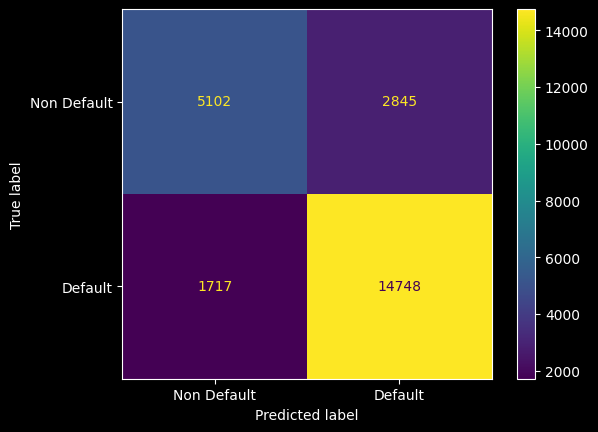

In [ ]:
#Nos quedamos con los mejores features:
del_feature= ['Best_Sit_C1','Worst_Sit_C1', 'Worst_Sit_C2']
data= dataset.drop(del_feature, axis=1)
np.random.seed(77)
data = data.groupby('Category').apply(lambda x: x.sample(frac=0.5)).reset_index(drop=True)

X= data.iloc[:,:-1]
y= data.iloc[:,-1]
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, stratify=y, random_state=77)

#Estandarizamos los datos
scaler= StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

#Prediction
logistic_cv = LogisticRegressionCV(cv=10, random_state=77, max_iter=5000)
logistic_cv.fit(X_train, y_train)
y_pred = logistic_cv.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
cm= confusion_matrix(y_test, y_pred)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non Default', 'Default'])
disp.plot()

### Decision Tree


In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

In [ ]:
data= dataset.drop(['Best_Sit_C1','Best_Sit_C2', 'Worst_Sit_C1', 'Worst_Sit_C2','Sit2_Pct' ,'Sit3_Pct'], axis=1)
#Eliminando data manteniendo la proporcion de las clases
np.random.seed(77)
data = data.groupby('Category').apply(lambda x: x.sample(frac=0.5)).reset_index(drop=True)

In [ ]:
X= data.iloc[:,:-1]
y= data.iloc[:,-1]

#Data splitting for training
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.20, stratify= y, random_state=77
)

X_train,X_val, y_train, y_val= train_test_split(
    X_train,y_train,test_size=0.25, random_state=77
)
#60% training
#20% validation
#20% testing

In [ ]:
#Prediction
model= DecisionTreeClassifier()
path= model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [ ]:
models = []
for ccp_alpha in ccp_alphas:
    model = DecisionTreeClassifier(criterion='gini',ccp_alpha=ccp_alpha)
    model.fit(X_train, y_train)
    models.append(model)

# Calcular el número de nodos y la profundidad del árbol
node_counts = [model.tree_.node_count for model in models]
depth = [model.tree_.max_depth for model in models]

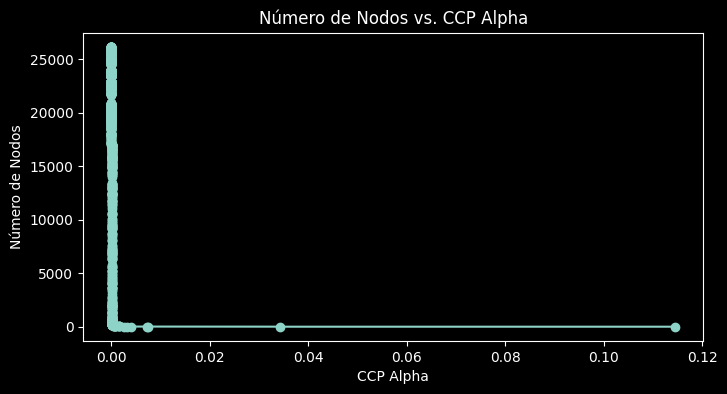

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
plt.xlabel("CCP Alpha")
plt.ylabel("Número de Nodos")
plt.title("Número de Nodos vs. CCP Alpha")
plt.show()

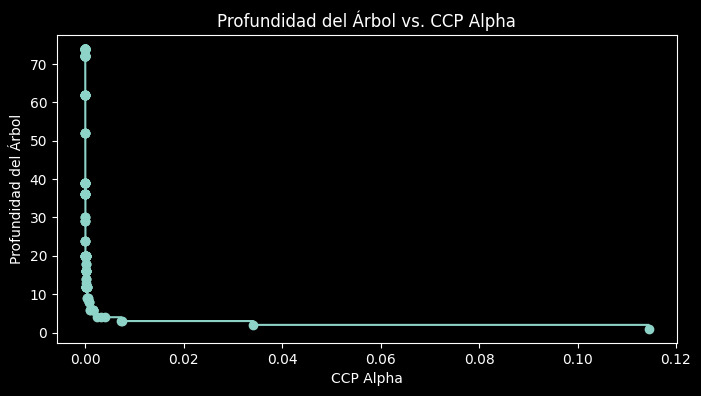

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
plt.xlabel("CCP Alpha")
plt.ylabel("Profundidad del Árbol")
plt.title("Profundidad del Árbol vs. CCP Alpha")
plt.show()

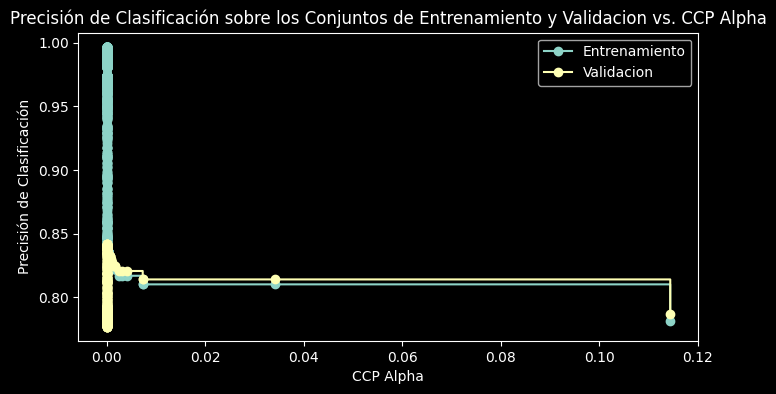

In [ ]:
train_accuracy = [accuracy_score(y_train, model.predict(X_train)) for model in models]
validation_accuracy = [accuracy_score(y_val, model.predict(X_val)) for model in models]

plt.figure(figsize=(8, 4))
plt.plot(ccp_alphas, train_accuracy, marker='o', label='Entrenamiento', drawstyle="steps-post")
plt.plot(ccp_alphas, validation_accuracy, marker='o', label='Validacion', drawstyle="steps-post")
plt.xlabel("CCP Alpha")
plt.ylabel("Precisión de Clasificación")
plt.title("Precisión de Clasificación sobre los Conjuntos de Entrenamiento y Validacion vs. CCP Alpha")
plt.legend()
plt.show()

In [ ]:
print(f"Se entrenan {len(ccp_alphas)} árboles")

Se entrenan 4628 árboles


In [ ]:
arg= np.argmax(validation_accuracy)
print(f"EL mejor valor para validation es {max(validation_accuracy)} y se da para ccp_alpha= {ccp_alphas[arg]}")
print(f"La profundidad de ese arbol es: {depth[arg]}")

EL mejor valor para validation s 0.8416762248074717 y se da para ccp_alpha= 0.00010185519856129011
La profundidad de ese arbol es: 20


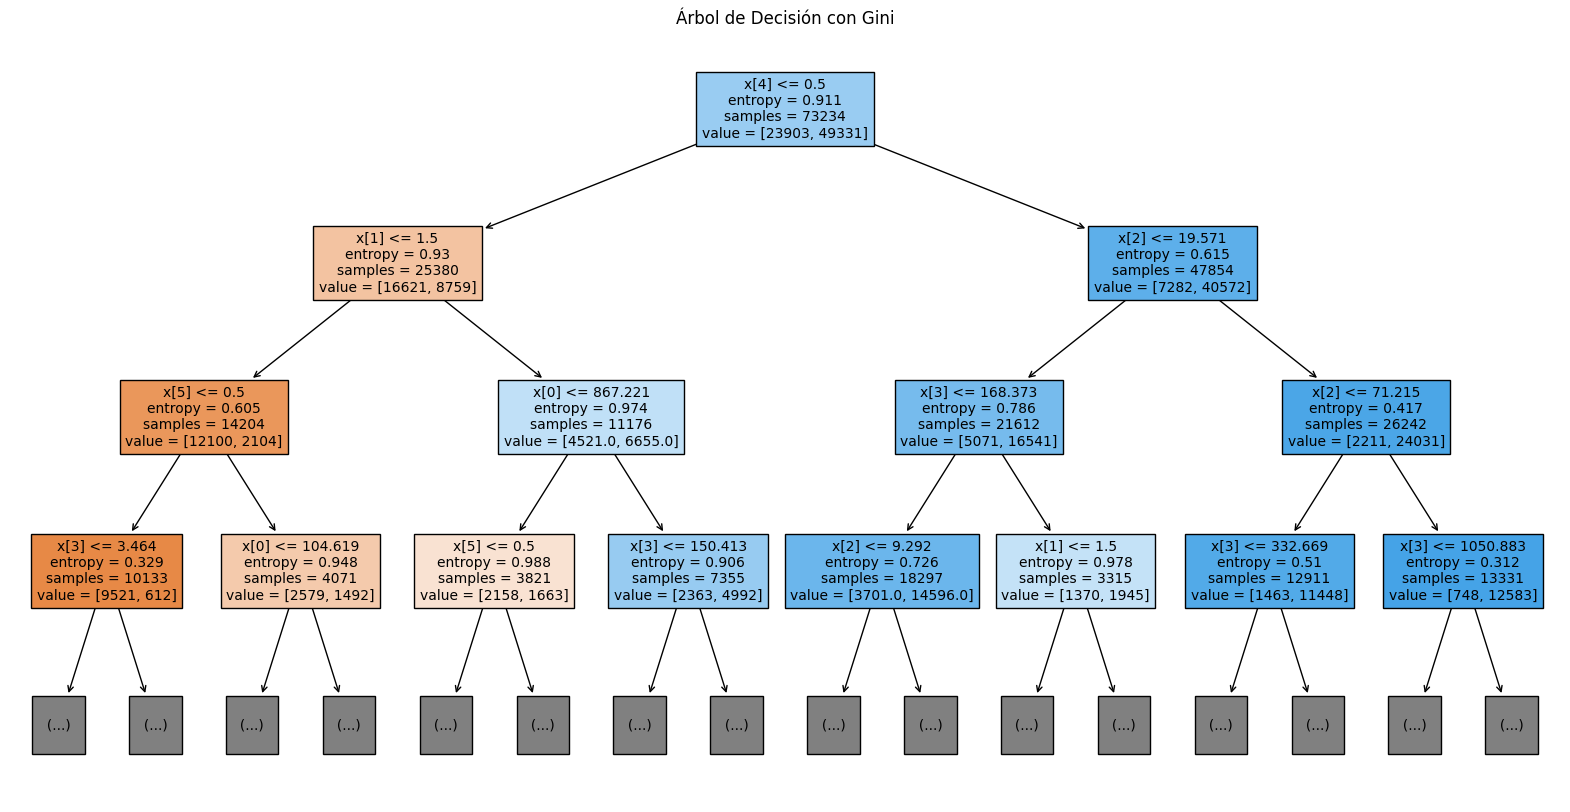

In [ ]:
plt.style.use("default")
plt.figure(figsize=(20, 10))
plot_tree(models[arg], filled=True, max_depth=3,fontsize=10)
plt.title("Árbol de Decisión con Gini")
plt.show()

In [ ]:
y_pred= models[arg].predict(X_test)
print(classification_report(y_test, y_pred))
cm= confusion_matrix(y_test, y_pred)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non Default', 'Default'])
disp.plot()

              precision    recall  f1-score   support

           0       0.81      0.66      0.73      7947
           1       0.85      0.93      0.89     16465

    accuracy                           0.84     24412
   macro avg       0.83      0.79      0.81     24412
weighted avg       0.84      0.84      0.84     24412



### Random Forest


In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
data= dataset
#Eliminando data manteniendo la proporcion de las clases
np.random.seed(77)
data = data.groupby('Category').apply(lambda x: x.sample(frac=0.5)).reset_index(drop=True)

In [ ]:
X= data.iloc[:,:-1]
y= data.iloc[:,-1]

#Data splitting for training
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.20, stratify= y, random_state=77
)

#Prediction
parameters= {'n_estimators': [30, 200, 300, 500], 'criterion':('gini', 'entropy')}
rf= RandomForestClassifier(random_state=77)
clf= GridSearchCV(rf, parameters, cv=10)
clf.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=77),
             param_grid={'criterion': ('gini', 'entropy'),
                         'n_estimators': [30, 200, 300, 500]})

Best weights: 500
Best value for k: entropy
Mean test score: 0.8421850405881937


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.69      0.74      7947
           1       0.86      0.92      0.89     16465

    accuracy                           0.85     24412
   macro avg       0.83      0.81      0.82     24412
weighted avg       0.84      0.85      0.84     24412



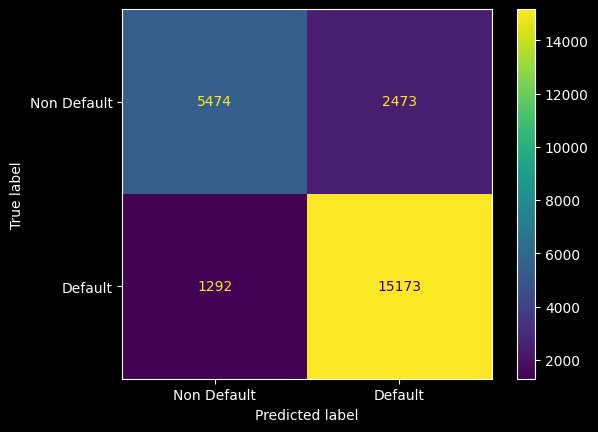

In [ ]:
#Best Parameters
best_n_estimators= clf.best_params_['n_estimators']
best_criterion= clf.best_params_['criterion']
mean_test_score= clf.cv_results_['mean_test_score'][clf.best_index_]
print("Best weights:", best_n_estimators)
print("Best value for k:", best_criterion)
print("Mean test score:", mean_test_score)

#Results
y_pred = clf.predict(X_test)
print("\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))
cm= confusion_matrix(y_test, y_pred)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non Default', 'Default'])
disp.plot()

### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import cohen_kappa_score

In [ ]:
data= dataset
#Eliminando data manteniendo la proporcion de las clases
np.random.seed(77)
data = data.groupby('Category').apply(lambda x: x.sample(frac=0.5)).reset_index(drop=True)

In [ ]:
X= data.iloc[:,:-1]
y= data.iloc[:,-1]

#Data splitting for training
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.20, stratify= y, random_state=77
)
#Prediction
parameters= {'learning_rate': [0.01, 0.1], 'n_estimators': [30, 200, 300],'max_depth': [3,5,10]}
gbc= GradientBoostingClassifier(random_state=77)
clf= GridSearchCV(gbc, parameters, cv=10)
clf.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=GradientBoostingClassifier(random_state=77),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 10],
                         'n_estimators': [30, 200, 300]})

Best value for learning_rate: 0.1
Best n_estimators: 300
Best max_depth: 5
Mean test score: 0.8533171291008508


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.69      0.76      7947
           1       0.86      0.94      0.90     16465

    accuracy                           0.86     24412
   macro avg       0.85      0.81      0.83     24412
weighted avg       0.86      0.86      0.85     24412



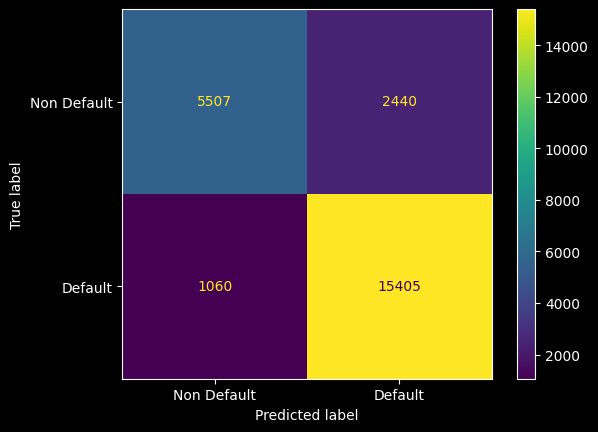

In [ ]:
#Best Parameters
best_learning_rate= clf.best_params_['learning_rate']
best_n_estimators= clf.best_params_['n_estimators']
best_max_depth= clf.best_params_['max_depth']
mean_test_score= clf.cv_results_['mean_test_score'][clf.best_index_]
print("Best value for learning_rate:", best_learning_rate)
print("Best n_estimators:", best_n_estimators)
print("Best max_depth:", best_max_depth)
print("Mean test score:", mean_test_score)

#Results
y_pred = clf.predict(X_test)
print("\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))
cm= confusion_matrix(y_test, y_pred)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non Default', 'Default'])
disp.plot()

In [ ]:
clf= GradientBoostingClassifier(learning_rate=0.1,n_estimators=300, max_depth=5, random_state=77)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

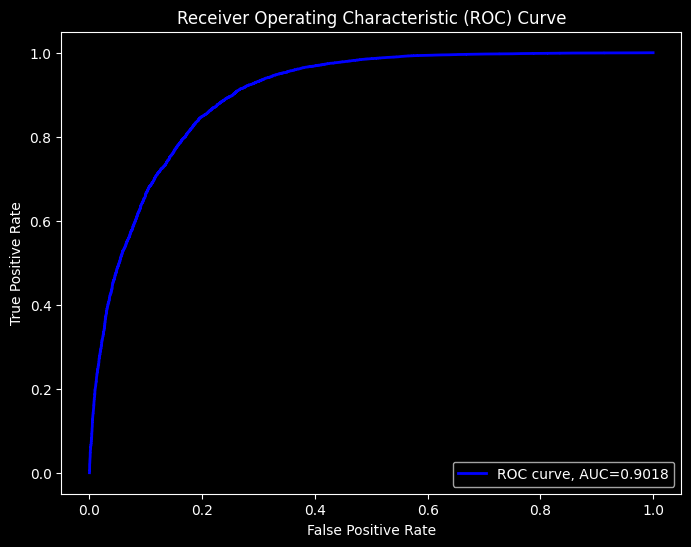

In [ ]:
y_probs = clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)

auc = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve, AUC={np.round(auc,4)}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()